In [1]:
import numpy as np
import pandas as pd
import keras 
import tensorflow as tf
import matplotlib.pyplot as plt
%matplotlib inline
import cv2
import glob
import os

C:\Users\huang\Anaconda3\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [2]:
training_fruit_img = []
training_label = []
for dir_path in glob.glob("fruits-360/Training/*"):
    img_label = dir_path.split("\\")[-1]
    for image_path in glob.glob(os.path.join(dir_path,"*.jpg")):
        image = cv2.imread(image_path,cv2.IMREAD_COLOR)
        image = cv2.resize(image, (64, 64))
        image = cv2.cvtColor(image, cv2.COLOR_RGB2BGR)
        training_fruit_img.append(image)
        training_label.append(img_label)
training_fruit_img = np.array(training_fruit_img)
training_label = np.array(training_label)

In [3]:
label_to_id = {v:k for k,v in enumerate(np.unique(training_label)) }
id_to_label = {v:k for k,v in label_to_id.items() }

In [4]:
pd.DataFrame(id_to_label,index=['image Label']).T[:5]

,image Label
0,Apple Braeburn
1,Apple Golden 1
2,Apple Golden 2
3,Apple Golden 3
4,Apple Granny Smith


In [5]:
training_label_id = np.array([label_to_id[i] for i in training_label])
training_label_id

array([ 0,  0,  0, ..., 70, 70, 70])

In [6]:
training_fruit_img.shape,training_label_id.shape

((35625, 64, 64, 3), (35625,))

In [7]:
validation_fruit_img=[]
validation_label =[]
for dir_path in glob.glob("fruits-360/Test/*"):
    img_label = dir_path.split("\\")[-1]
    for image_path in glob.glob(os.path.join(dir_path,"*.jpg")):
        image = cv2.imread(image_path,cv2.IMREAD_COLOR)
        image = cv2.resize(image, (64, 64))
        image = cv2.cvtColor(image, cv2.COLOR_RGB2BGR)
        validation_fruit_img.append(image)
        validation_label.append(img_label)
validation_fruit_img = np.array(validation_fruit_img)
validation_label = np.array(validation_label)

In [8]:
validation_label_id = np.array([label_to_id[i] for i in validation_label])
validation_label_id

array([ 0,  0,  0, ..., 70, 70, 70])

In [9]:
validation_fruit_img.shape,validation_label_id.shape

((11968, 64, 64, 3), (11968,))

In [10]:
X_train,X_test = training_fruit_img,validation_fruit_img
Y_train,Y_test =training_label_id,validation_label_id
#mean(X) = np.mean(X_train)
X_train = X_train/255
X_test = X_test/255

# X_flat_train = X_train.reshape(X_train.shape[0],64*64*3)
# X_flat_test = X_test.reshape(X_test.shape[0],64*64*3)

#One Hot Encode the Output
from keras.utils import to_categorical
num_of_classes = 65
Y_train = to_categorical(Y_train)
Y_test = to_categorical(Y_test)

# from keras.utils import to_categorical
# to_categorical(Y_test, 65)

# y_train = pd.get_dummies(Y_train)
# y_test = pd.get_dummies(Y_test)

print('Original Sizes:')
print('   - X_train:', X_train.shape)
print('   - X_test: ', X_test.shape)
print('   - Y_train:', Y_train.shape)
print('   - Y_test: ', Y_test.shape)

# print('Flattened:')
# print('   - X_flat_train:', X_flat_train.shape)
# print('   - X_flat_test: ', X_flat_test.shape)

Original Sizes:
   - X_train: (35625, 64, 64, 3)
   - X_test:  (11968, 64, 64, 3)
   - Y_train: (35625, 71)
   - Y_test:  (11968, 71)


(64, 64, 3)


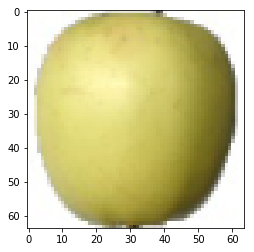

In [11]:
print(X_train[1200].shape)
plt.imshow(X_train[1200])
plt.show()

In [12]:
# Create model
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Dense, Dropout, Flatten
from keras.layers import Activation, BatchNormalization, regularizers

model = Sequential()

model.add(Conv2D(16, (3, 3), input_shape=(64,64,3)))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Conv2D(16, (3, 3)))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2,2)))

model.add(Conv2D(32,(3,3 )))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Conv2D(32, (3, 3)))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2,2)))

model.add(Conv2D(64, (3, 3)))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2,2)))


model.add(Flatten())

# Fully connected layer
model.add(Dense(512))
model.add(BatchNormalization())
model.add(Activation('relu'))
model.add(Dropout(0.5))
model.add(Dense(71))

model.add(Activation('softmax'))
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 62, 62, 16)        448       
_________________________________________________________________
batch_normalization_1 (Batch (None, 62, 62, 16)        64        
_________________________________________________________________
activation_1 (Activation)    (None, 62, 62, 16)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 60, 60, 16)        2320      
_________________________________________________________________
batch_normalization_2 (Batch (None, 60, 60, 16)        64        
_________________________________________________________________
activation_2 (Activation)    (None, 60, 60, 16)        0         
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 30, 30, 16)        0         
__________

In [13]:
# compile model
model.compile(optimizer='rmsprop',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

In [14]:
# model.fit(X_train,
#           Y_train,
#           batch_size=128,
#           epochs=10,
#           verbose=1,
#           validation_data = (X_test,Y_test)
#          )

train_model_1 = model.fit(X_train, Y_train, 
                          batch_size=64, epochs=10, 
                          verbose=1, validation_data=(X_test, Y_test))

Train on 35625 samples, validate on 11968 samples
Epoch 1/10
35625/35625 [==============================] - 756s 21ms/step - loss: 0.2547 - acc: 0.9363 - val_loss: 0.4374 - val_acc: 0.8678
Epoch 2/10
35625/35625 [==============================] - 749s 21ms/step - loss: 0.0370 - acc: 0.9887 - val_loss: 0.3571 - val_acc: 0.9058
Epoch 3/10
35625/35625 [==============================] - 748s 21ms/step - loss: 0.0284 - acc: 0.9898 - val_loss: 0.1825 - val_acc: 0.9511
Epoch 4/10
35625/35625 [==============================] - 747s 21ms/step - loss: 0.0252 - acc: 0.9900 - val_loss: 0.1415 - val_acc: 0.9623
Epoch 5/10
35625/35625 [==============================] - 747s 21ms/step - loss: 0.0208 - acc: 0.9917 - val_loss: 0.2501 - val_acc: 0.9403
Epoch 6/10
35625/35625 [==============================] - 748s 21ms/step - loss: 0.0208 - acc: 0.9911 - val_loss: 0.6846 - val_acc: 0.8782
Epoch 7/10
35625/35625 [==============================] - 748s 21ms/step - loss: 0.0184 - acc: 0.9922 - val_loss: 0.

In [25]:
pd.DataFrame(train_model_1.history)

,acc,loss,val_acc,val_loss
0,0.936337,0.254717,0.867814,0.437390
1,0.988660,0.037037,0.905832,0.357079
2,0.989754,0.028450,0.951120,0.182526
3,0.990007,0.025173,0.962316,0.141505
4,0.991663,0.020784,0.940341,0.250132
5,0.991074,0.020832,0.878175,0.684621
6,0.992168,0.018439,0.939255,0.263892
7,0.992196,0.016474,0.951788,0.188913
8,0.992281,0.016966,0.927390,0.402354
9,0.992309,0.016167,0.949532,0.292905


In [18]:
from keras.models import save_model
save_model(model, 'HP.HDF5')

In [75]:
def predict_img(path):
    img_label = path.split("\\")[-1]
    image = cv2.imread(path,cv2.IMREAD_COLOR)
    image = cv2.cvtColor(image, cv2.COLOR_RGB2BGR)
    plt.imshow(image)
    plt.show()
    image = cv2.resize(image, (64, 64))
    image = image/255
    image = image.reshape(1,64,64,3)
    print(image.shape)
    label = model.predict_classes(image)
    print(label)    

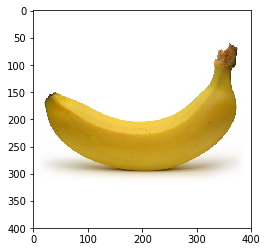

(1, 64, 64, 3)
[13]


In [76]:
path = r"E:\CBD\16.Fruit-classification-using-CNN\fruits-360\To_predict\a_banana.jpg"
predict_img(path)

In [83]:
Y_train.argmax(13,axis=1)

TypeError: Argument given by name ('axis') and position (1)

In [90]:
Y_train

array([[1., 0., 0., ..., 0., 0., 0.],
       [1., 0., 0., ..., 0., 0., 0.],
       [1., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 1.],
       [0., 0., 0., ..., 0., 0., 1.],
       [0., 0., 0., ..., 0., 0., 1.]], dtype=float32)